In [17]:
from process_bigraph import Process, ProcessTypes, Composite
import matplotlib.pyplot as plt
import cobra
from cobra.io import load_model

core = ProcessTypes()


In [18]:
# create new types
def apply_non_negative(schema, current, update, core):
    new_value = current + update
    return max(0, new_value)

positive_float = {
    '_type': 'positive_float',
    '_inherit': 'float',
    '_apply': apply_non_negative
}
core.register('positive_float', positive_float)

bounds_type = {
    'lower': 'maybe[float]',
    'upper': 'maybe[float]'
}
core.register_process('bounds', bounds_type)


# TODO -- check the function signature of the apply method and report missing keys upon registration

In [19]:
core.access('positive_float')

{'_type': 'positive_float',
 '_check': 'check_float',
 '_apply': 'apply_non_negative',
 '_serialize': 'to_string',
 '_description': '64-bit floating point precision number',
 '_default': '0.0',
 '_deserialize': 'deserialize_float',
 '_divide': 'divide_float',
 '_dataclass': 'dataclass_float',
 '_inherit': ['float']}

# Dynamic FBA Process

In [20]:
class DynamicFBA(Process):
    """
    Performs dynamic FBA.

    Parameters:
    - model: The metabolic model for the simulation.
    - kinetic_params: Kinetic parameters (Km and Vmax) for each substrate.
    - biomass_reaction: The identifier for the biomass reaction in the model.
    - substrate_update_reactions: A dictionary mapping substrates to their update reactions.
    - biomass_identifier: The identifier for biomass in the current state.
    
    TODO -- check units
    """
    
    config_schema = {
        'model_file': 'string',
        'kinetic_params': 'map[tuple[float,float]]',
        'biomass_reaction': {
            '_type': 'string',
            '_default': 'Biomass_Ecoli_core'
        },
        'substrate_update_reactions': 'map[string]',
        'biomass_identifier': 'string',
        'bounds': 'map[bounds]',
    }
  
    def __init__(self, config, core):
        super().__init__(config, core)
        
        if not 'xml' in self.config['model_file']:
            # use the textbook model if no model file is provided
            self.model = load_model(self.config['model_file'])
        else:
            self.model = cobra.io.read_sbml_model(self.config['model_file'])
            
        for reaction_id, bounds in self.config['bounds'].items():
            if bounds['lower'] is not None:
                self.model.reactions.get_by_id(reaction_id).lower_bound = bounds['lower']
            if bounds['upper'] is not None:
                self.model.reactions.get_by_id(reaction_id).upper_bound = bounds['upper']
        
    def inputs(self):
        return {'substrates': 'map[positive_float]'}
    
    def outputs(self):
        return {'substrates': 'map[positive_float]'}
    
    # TODO -- can we just put the inputs/outputs directly in the function?
    def update(self, state, interval):
        substrates_input = state['substrates']
        
        for substrate, reaction_id in self.config['substrate_update_reactions'].items():
            Km, Vmax = self.config['kinetic_params'][substrate]
            substrate_concentration = substrates_input[substrate]
            uptake_rate = Vmax * substrate_concentration / (Km + substrate_concentration)
            self.model.reactions.get_by_id(reaction_id).lower_bound = -uptake_rate
    
        substrate_update = {}
    
        solution = self.model.optimize()
        if solution.status == 'optimal':
            current_biomass = substrates_input[self.config['biomass_identifier']]
            biomass_growth_rate = solution.fluxes[self.config['biomass_reaction']]
            substrate_update[self.config['biomass_identifier']] = biomass_growth_rate * current_biomass * interval
    
            for substrate, reaction_id in self.config['substrate_update_reactions'].items():
                flux = solution.fluxes[reaction_id]
                substrate_update[substrate] = flux * current_biomass * interval   
                # TODO -- assert not negative?
        else:
            # Handle non-optimal solutions if necessary
            print('Non-optimal solution, skipping update')
            for substrate, reaction_id in self.config['substrate_update_reactions'].items():
                substrate_update[substrate] = 0

        return {
            'substrates': substrate_update,
        }

core.register_process('DynamicFBA', DynamicFBA)

In [21]:
from process_bigraph.experiments.parameter_scan import RunProcess

# TODO -- this should be imported, or just part of Process?
def run_process(
        address, 
        config, 
        core_type, 
        initial_state, 
        observables, 
        timestep=1, 
        runtime=10
):
    config = {
        'process_address': address,
        'process_config': config,
        'observables': observables,
        'timestep': timestep,
        'runtime': runtime}
          
    run = RunProcess(config, core_type)
    return run.update(initial_state)

In [22]:
config = {
    'model_file': 'textbook',
    'kinetic_params': {
        'glucose': (0.5, 1),
        'acetate': (0.5, 2)
    },
    'biomass_reaction': 'Biomass_Ecoli_core',
    'substrate_update_reactions': {
        'glucose': 'EX_glc__D_e',
        'acetate': 'EX_ac_e'
    },
    'biomass_identifier': 'biomass',
    'bounds': {
        'EX_o2_e': {'lower': -2, 'upper': None},
        'ATPM': {'lower': 1, 'upper': 1}
    }
}

initial_state = {
    'substrates': {
        'biomass': 0.1,  # Initial biomass concentration
        'glucose': 20.0, # Initial glucose concentration
        'acetate': 0.0   # Initial acetate concentration
    }
}

results = run_process(
    address='local:DynamicFBA', 
    config=config, 
    core_type=core, 
    initial_state=initial_state,
    observables=[['substrates', 'glucose'], 
                 ['substrates', 'acetate'],
                 ['substrates', 'biomass']], 
    timestep=0.1, 
    runtime=100,
)

Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal solution, skipping update
Non-optimal 

In [23]:
results['results'].keys()

dict_keys(['substrates', 'time'])

In [24]:
print(results['results']['substrates']['acetate'])

[0.0, 0.0016745886864195005, 0.0033624239164152196, 0.005063608230860864, 0.0067782449233747665, 0.008506438045045486, 0.010248292409169827, 0.012003913596002669, 0.01377340795751824, 0.015556882622182437, 0.01735444549973555, 0.01916620528598513, 0.020992271467608216, 0.022832754326962704, 0.024687764946907012, 0.026557415215627666, 0.028441817831474075, 0.030341086307800205, 0.032255334977812, 0.03418467899942049, 0.03612923436009944, 0.03808911788174716, 0.04006444722555163, 0.04205534089685836, 0.044061918250039786, 0.0460842994933661, 0.04812260569387628, 0.05017695878224835, 0.05224748155766848, 0.054334297692697694, 0.05643753173813543, 0.05855730912787891, 0.06069375618377739, 0.06284700012048035, 0.06501716905027861, 0.0672043919879372, 0.0694087988555189, 0.07163052048719747, 0.07386968863405928, 0.0761264359688922, 0.07840089609096058, 0.08069320353076469, 0.08300349375478404, 0.08533190317020252, 0.08767856912961426, 0.09004362993570886, 0.09242722484593453, 0.0948294940771

In [25]:
# plot results
def plot_results(results):
    fig, ax = plt.subplots()
    for key, value in results['substrates'].items():
        ax.plot(results['time'], value, label=key)
    ax.legend()
    plt.show()

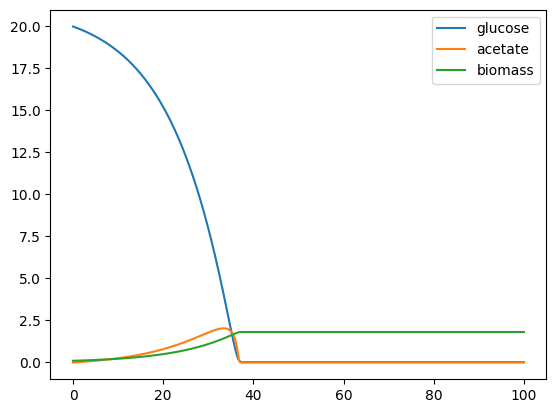

In [26]:
plot_results(results['results'])

In [27]:
# model.reactions.EX_o2_e.lower_bound = -2  # Limiting oxygen uptake
# model.reactions.ATPM.lower_bound = 1     # Setting lower bound for ATP maintenance
# model.reactions.ATPM.upper_bound = 1     # Setting upper bound for ATP maintenance
# 
# # Define initial conditions, kinetic parameters, and other necessary inputs
# initial_conditions = {
#     'biomass': 0.1,  # Initial biomass concentration
#     'glucose': 20.0, # Initial glucose concentration
#     'acetate': 0.0   # Initial acetate concentration
# }
# kinetic_params = {
#     'glucose': (0.5, 2), # Km and Vmax for glucose
#     'acetate': (0.5, 2)  # Km and Vmax for acetate
# }
# substrate_update_reactions = {
#     'glucose': 'EX_glc__D_e',  # Exchange reaction ID for glucose
#     'acetate': 'EX_ac_e'       # Exchange reaction ID for acetate
# }
# 
# # simulation conditions
# t_n = 100 # number of time points
# dt = 0.5  # Time step, matching your setup
# time_points = list(range(0, t_n))  # Simulation time points, matching your setup
# 
# # Make sure to adjust the perform_dfba function if needed to initialize result arrays with sufficient size
# dfba_results = perform_dfba(
#     model, 
#     initial_conditions, 
#     kinetic_params, 
#     time_points, 
#     'Biomass_Ecoli_core', 
#     substrate_update_reactions, 
#     dt,
#     'biomass'
# )